# Contracting a large output lazily

In this example we generate perform a contraction with an 
output that would be larger than can fit in memory. 
However we can still generate it in chunks which is 
sufficient to compute for example:

$$
S = - \sum_{\{a, b, c, \ldots\}} p_{a, b, c, \ldots} \log p_{a, b, c, \ldots}
$$

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cotengra as ctg
import quimb.tensor as qtn
from autoray import do

Use quimb to make an example factor graph / probability distribution:

In [2]:
htn = qtn.HTN3D_classical_ising_partition_function(
    6, 6, 6, beta=0.3,
)

Here we optionally first convert the tensor network's data to cupy GPU arrays:

In [3]:
def to_backend(x):
    import cupy

    return cupy.asarray(x, dtype="float32")

htn.apply_to_arrays(to_backend)

Select a subset of output variables (more than we can store the full tensor for!):

In [4]:
output_inds = tuple(
    f"s{i},{j},{k}"
    for i in range(4)
    for j in range(3)
    for k in range(3)
)
len(output_inds)

36

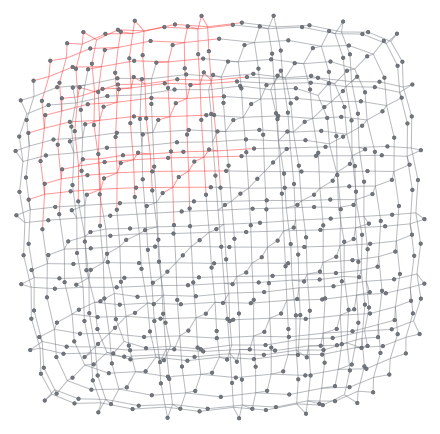

In [5]:
htn.draw(highlight_inds=output_inds)

In [6]:
opt = ctg.ReusableHyperOptimizer(
    minimize='combo',
    # here we put the actual amount of storage we are limited to
    slicing_reconf_opts={'target_size': 2**28},
    # the amount of time we want to spend searching 
    # given we can compute at approximately 1e10 ops / sec
    max_time="rate:1e11",
    progbar=True,
)

First if we need to normalize we compute the full partition function:

In [7]:
tree_Z = htn.contraction_tree(output_inds=(), optimize=opt)

log2[SIZE]: 28.00 log10[FLOPs]: 12.80:  24%|█████████▉                               | 31/128 [01:04<03:22,  2.09s/it]


Since it could be a very large or small number we actively renormalize the
tensors while contracting into a separate mantissa and exponent:

In [8]:
Z_mantissa, Z_exponent = tree_Z.contract(
    htn.arrays, strip_exponent=True, progbar=True
)
Z_mantissa, Z_exponent

100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.56it/s]


(array(4.2891397, dtype=float32), array(78.32228, dtype=float32))

In [9]:
# we can perform a normalization by setting the negative exponent
htn.exponent = -Z_exponent
# this then spreads the exponent among all the actual tensors
htn.equalize_norms_()

TensorNetwork(tensors=540, indices=216)

Then we can compute the output marginal contraction tree, which for factor
graphs is just of matter of re-interprating certain indices as 'outputs':

In [10]:
tree_sub = htn.contraction_tree(output_inds=output_inds, optimize=opt)

log2[SIZE]: 28.00 log10[FLOPs]: 13.46: 100%|████████████████████████████████████████| 128/128 [01:39<00:00,  1.29it/s]


the output tensor is larger than our sliced size so we generate the output
chunks lazily, which we can process one by one:

In [11]:
S = sum(
    # using autoray handles numpy/cupy/torch/jax etc.
    -do("sum", p_chunk * do("log", p_chunk))
    for p_chunk in tree_sub.gen_output_chunks(
        htn.arrays,  progbar=True,
    )
)

100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [02:15<00:00,  1.89it/s]


In [12]:
S

array(56.018044, dtype=float32)